<h2 style="color: #FF6347;">Importing Necessary Libraries</h2>

In [1]:
# Basic Libraries
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

import os
import shutil
from sklearn.model_selection import train_test_split
from random import shuffle
from PIL import Image, ImageOps

from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
base_dir = "/Users/davidthrien/Documents/Ironhack/Ironhack_labs/Week8/Project Computer Vision Parking Lot Detection/parking/clf-data"
model_data_dir = "/Users/davidthrien/Documents/Ironhack/Ironhack_labs/Week8/Project Computer Vision Parking Lot Detection/parking/model_data" 

resized_dir = "/Users/davidthrien/Documents/Ironhack/Ironhack_labs/Week8/Project Computer Vision Parking Lot Detection/parking/resized_with_padding"

In [3]:
# Batch sizes are usually in powers of 2: 32, 64, 128, 256, etc.
batch_size = 32

# MobileNetV2 model expects input images to be 160 x 160 pixels
# But usually powers of 2 are used for image size: 128 x 128 or 256 x 256
img_size = (32, 68)

In [4]:
train_dir = os.path.join(model_data_dir, 'train')
validation_dir = os.path.join(model_data_dir, 'val')

In [5]:
# Verify train and validation directories
print("Train directory contents:", os.listdir(train_dir))
print("Validation directory contents:", os.listdir(validation_dir))

Train directory contents: ['empty', 'not_empty']
Validation directory contents: ['empty', 'not_empty']


In [6]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, batch_size=batch_size, image_size=img_size)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir, shuffle=True, batch_size=batch_size, image_size=img_size)

Found 4872 files belonging to 2 classes.
Found 1218 files belonging to 2 classes.


In [7]:
class_names = train_dataset.class_names

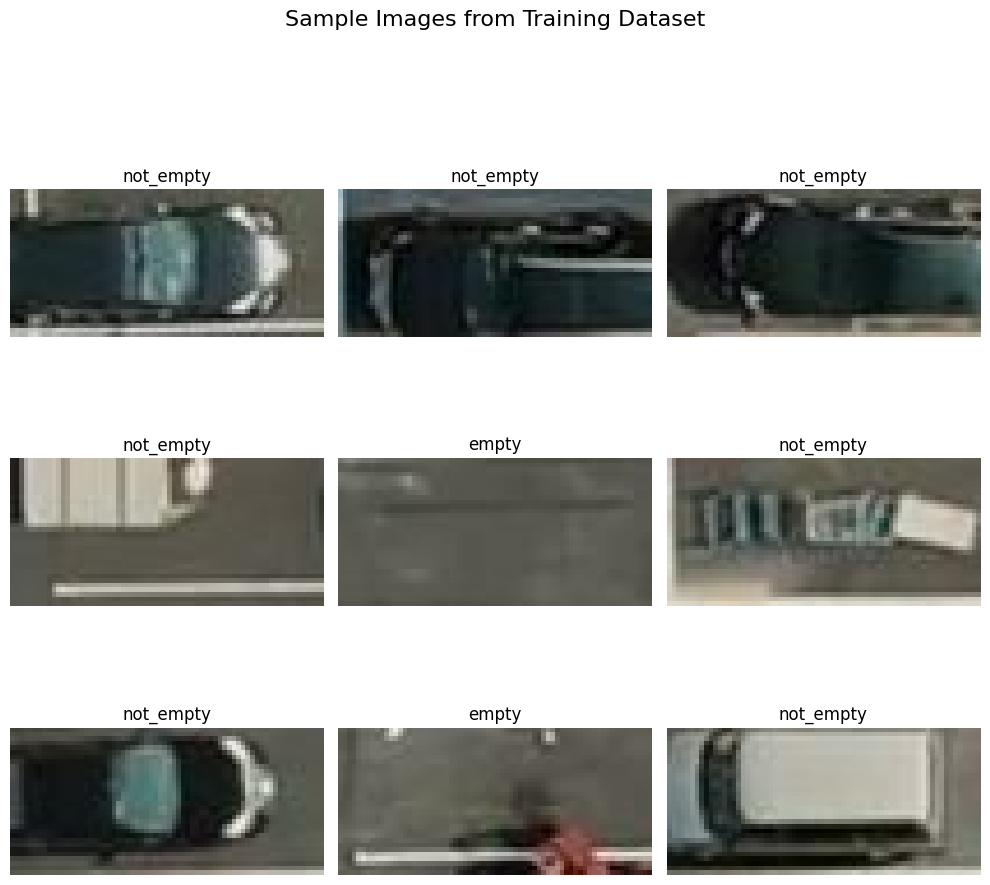

In [56]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Sample Images from Training Dataset", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [9]:
# Split validation set into validation and test datasets
val_batches = tf.data.experimental.cardinality(validation_dataset)

# val_vatches object is a tensor, so we need to convert it to a number

In [10]:
int(val_batches)

39

In [11]:
test_dataset = validation_dataset.take(val_batches // 5) # val_batches // 5 is 20% of the validation dataset
validation_dataset = validation_dataset.skip(val_batches // 5) # 80% of the validation dataset

In [12]:
print('Number of validation batches:', tf.data.experimental.cardinality(validation_dataset).numpy())
print('Number of test batches:', tf.data.experimental.cardinality(test_dataset).numpy())

Number of validation batches: 32
Number of test batches: 7


In [13]:
tf.data.AUTOTUNE

-1

In [14]:
autotune = tf.data.AUTOTUNE

In [15]:
# Optimize dataset performance with prefetching
train_dataset = train_dataset.prefetch(buffer_size=autotune)
validation_dataset = validation_dataset.prefetch(buffer_size=autotune)
test_dataset = test_dataset.prefetch(buffer_size=autotune)

<h2 style="color: #FF6347;">Data Augmentation</h2>

In [16]:
# Data Augmentation
horizontal_flips = tf.keras.layers.RandomFlip('horizontal')
radians = tf.keras.layers.RandomRotation(0.02)

In [17]:
data_augmentation = tf.keras.Sequential([
   horizontal_flips,
   radians
])

2025-04-10 11:41:32.412665: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


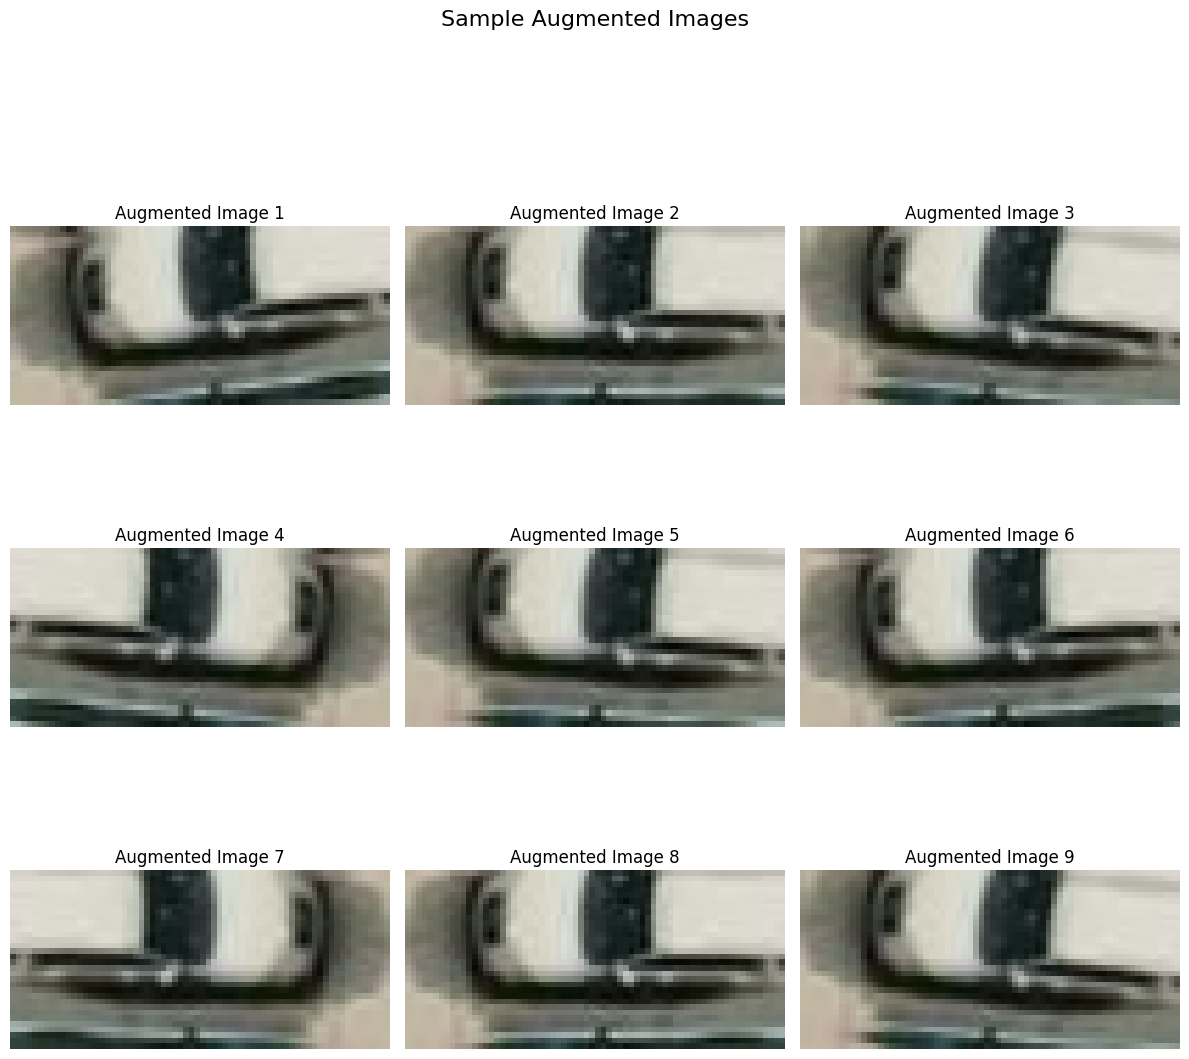

In [18]:
# Visualize augmented images
plt.figure(figsize=(12, 12))
for images, _ in train_dataset.take(1):
    sample_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(f"Augmented Image {i+1}", fontsize=12)
plt.suptitle("Sample Augmented Images", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

<h2 style="color: #FF6347;">Transfer Learning with MobileNetV2</h2>

In [19]:
img_shape = img_size + (3,)

In [20]:
img_size

(32, 68)

In [21]:
img_shape

(32, 68, 3)

<h3 style="color: #FF6347;">CNN Architecture</h3>

In [22]:
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape, 
                                               include_top=False, # Exclude the ImageNet classifier at the top
                                               weights='imagenet') # Use the pre-trained weights from ImageNet

/var/folders/1m/50y9vknn1lx05wgwhbgqtdh80000gn/T/ipykernel_29430/2849005504.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,


In [23]:
base_model.trainable = False # Freeze the base model to keep the pre-trained weights

In [24]:
inputs = tf.keras.Input(shape=img_shape)
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)

In [25]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # layer object

# Apply the layer to MobileNetV2
x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.2)(x) ### Optional: Add a dropout layer

prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid') # layer object
# Apply Fully Connected Layer to predict the class
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [26]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 68, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 32, 68, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 32, 68, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 32, 68, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

<h2 style="color: #FF6347;">Training the Model</h2>

In [27]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=batch_size, # Learning rate will decrease every batch
    decay_rate=0.8
) # rate of decrease means 80% of the learning rate is decreased

In [28]:
# Compile the model structure for training
base_learning_rate = 0.05
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), # Adam deals with gradient descent
              loss=tf.keras.losses.BinaryCrossentropy(), # measures the difference between two probability distributions
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')]) # calculates how often predictions match binary labels

In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [30]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)

In [31]:
initial_epochs = 50

<h3 style="color: #FF8C00;">Training & Saving (Best Model + Metrics)</h3>

In [32]:
import json

# Train the model with callbacks
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset,
    callbacks=[early_stopping, model_checkpoint], # Callbacks are used to customize the training process
    verbose=1  # Verbosity level: 1 = progress bar, 2 = one line per epoch
)

# Save training history
with open('training_history.json', 'w') as file: # open creates a file
    json.dump(history.history, file) # dump saves it as a json file

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9300 - loss: 0.2654 - val_accuracy: 0.9940 - val_loss: 0.0368
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9890 - loss: 0.0412 - val_accuracy: 0.9909 - val_loss: 0.0507
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9951 - loss: 0.0279 - val_accuracy: 0.9950 - val_loss: 0.0247
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9952 - loss: 0.0274 - val_accuracy: 0.9950 - val_loss: 0.0220
Epoch 5/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9960 - loss: 0.0213 - val_accuracy: 0.9950 - val_loss: 0.0236
Epoch 6/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9948 - loss: 0.0260 - val_accuracy: 0.9950 - val_loss: 0.0227
Epoch 7/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9953 - loss: 0.0262 - val_accuracy: 0.9950 - val_loss: 0.0226
Epoch 8/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9951 - loss: 0.0236 - val_accu

<h2 style="color: #FF6347;">Fine-Tuning the Model</h2>

In [33]:
# Unfreeze some layers for fine-tuning
base_model.trainable = True

In [34]:
len(base_model.layers)

154

In [35]:
for layer in base_model.layers[:100]: # Freeze the first 100 layers
    layer.trainable = False

In [36]:
base_learning_rate
fine_tune_learning_rate = base_learning_rate / 10 # 10 times smaller learning rate for fine-tuning

In [37]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_learning_rate),  # Smaller learning rate
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')]
)

In [38]:
# Same callbacks
fine_tune_early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
fine_tune_model_checkpoint = ModelCheckpoint(filepath='fine_tuned_model.keras', monitor='val_loss', save_best_only=True)


# Define fine-tuning epochs
fine_tune_epochs = 50
total_epochs = initial_epochs + fine_tune_epochs

In [39]:
# Fine-tune the model
history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],  # Continue from where the initial training ended
    validation_data=validation_dataset,
    callbacks=[fine_tune_early_stopping, fine_tune_model_checkpoint],  # Add callbacks
    verbose=1
)

# Save fine-tuning history
with open('fine_tuning_history.json', 'w') as file:
    json.dump(history_fine.history, file)

Epoch 11/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9552 - loss: 0.2105 - val_accuracy: 0.9809 - val_loss: 0.5108
Epoch 12/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9938 - loss: 0.0138 - val_accuracy: 0.9779 - val_loss: 0.1967
Epoch 13/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9954 - loss: 0.0152 - val_accuracy: 0.9980 - val_loss: 0.0045
Epoch 14/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9990 - loss: 0.0056 - val_accuracy: 0.9879 - val_loss: 0.2383
Epoch 15/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9987 - loss: 0.0034 - val_accuracy: 0.9950 - val_loss: 0.0162
Epoch 16/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9999 - loss: 1.7867e-04 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 17/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9999 - loss: 3.0091e-04 - val_accuracy: 0.9990 - val_loss: 0.0023
Epoch 18/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9870 -

<h2 style="color: #FF6347;">Evaluating and Visualizing Results</h2>

In [40]:
# Using the best model
model = tf.keras.models.load_model('fine_tuned_model.keras')

In [41]:
# Evaluate the fine-tuned model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - loss: 6.7206e-04


In [42]:
# Load training history
with open('training_history.json', 'r') as file:
    training_history = json.load(file)

# Load fine-tuning history
with open('fine_tuning_history.json', 'r') as file:
    fine_tuning_history = json.load(file)

In [43]:
# Combine training and fine-tuning metrics
acc = training_history['accuracy'] + fine_tuning_history['accuracy']
val_acc = training_history['val_accuracy'] + fine_tuning_history['val_accuracy']

loss = training_history['loss'] + fine_tuning_history['loss']
val_loss = training_history['val_loss'] + fine_tuning_history['val_loss']

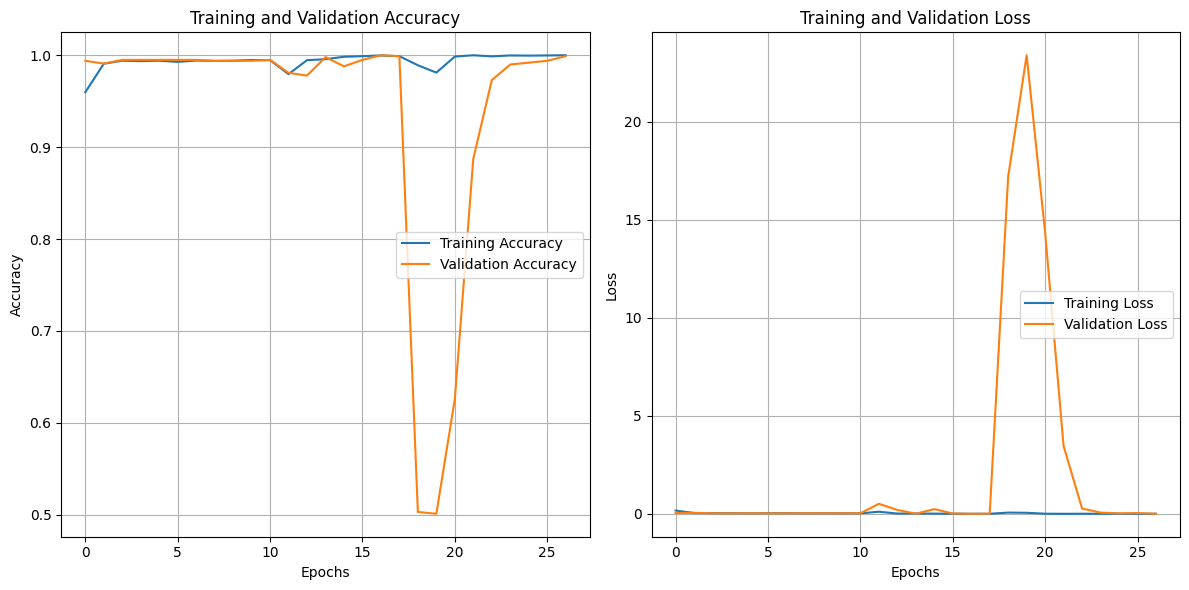

In [44]:
# Plot accuracy and loss on the same grid
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.5))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Gather ground truth and predictions from the test dataset
#ground_truth = np.concatenate([labels.numpy() for _, labels in test_dataset]) 
#predictions = np.concatenate([tf.where(model(X).numpy().flatten() < 0.5, 0, 1).numpy() for X, _ in test_dataset]) 


In [ ]:
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images).flatten()
    bin_preds = (predictions > 0.5).astype("int32")

    y_true.extend(labels.numpy())
    y_pred.extend(bin_preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


2025-04-10 11:44:06.332122: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

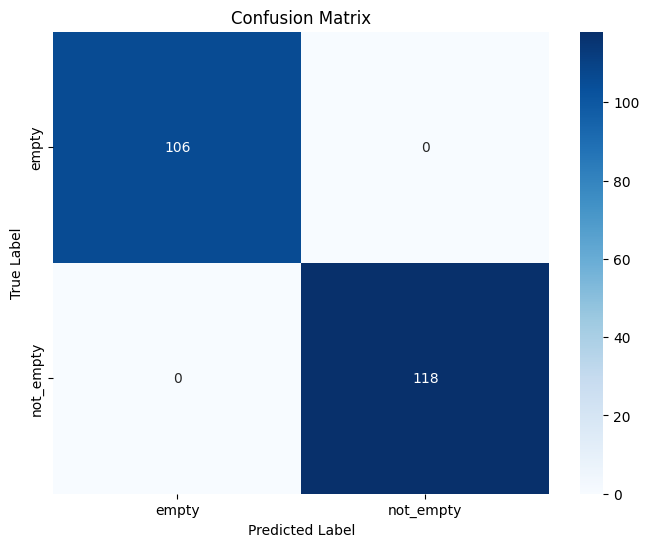

In [48]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [49]:
from sklearn.metrics import classification_report

In [51]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

       empty       1.00      1.00      1.00       106
   not_empty       1.00      1.00      1.00       118

    accuracy                           1.00       224
   macro avg       1.00      1.00      1.00       224
weighted avg       1.00      1.00      1.00       224



In [52]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

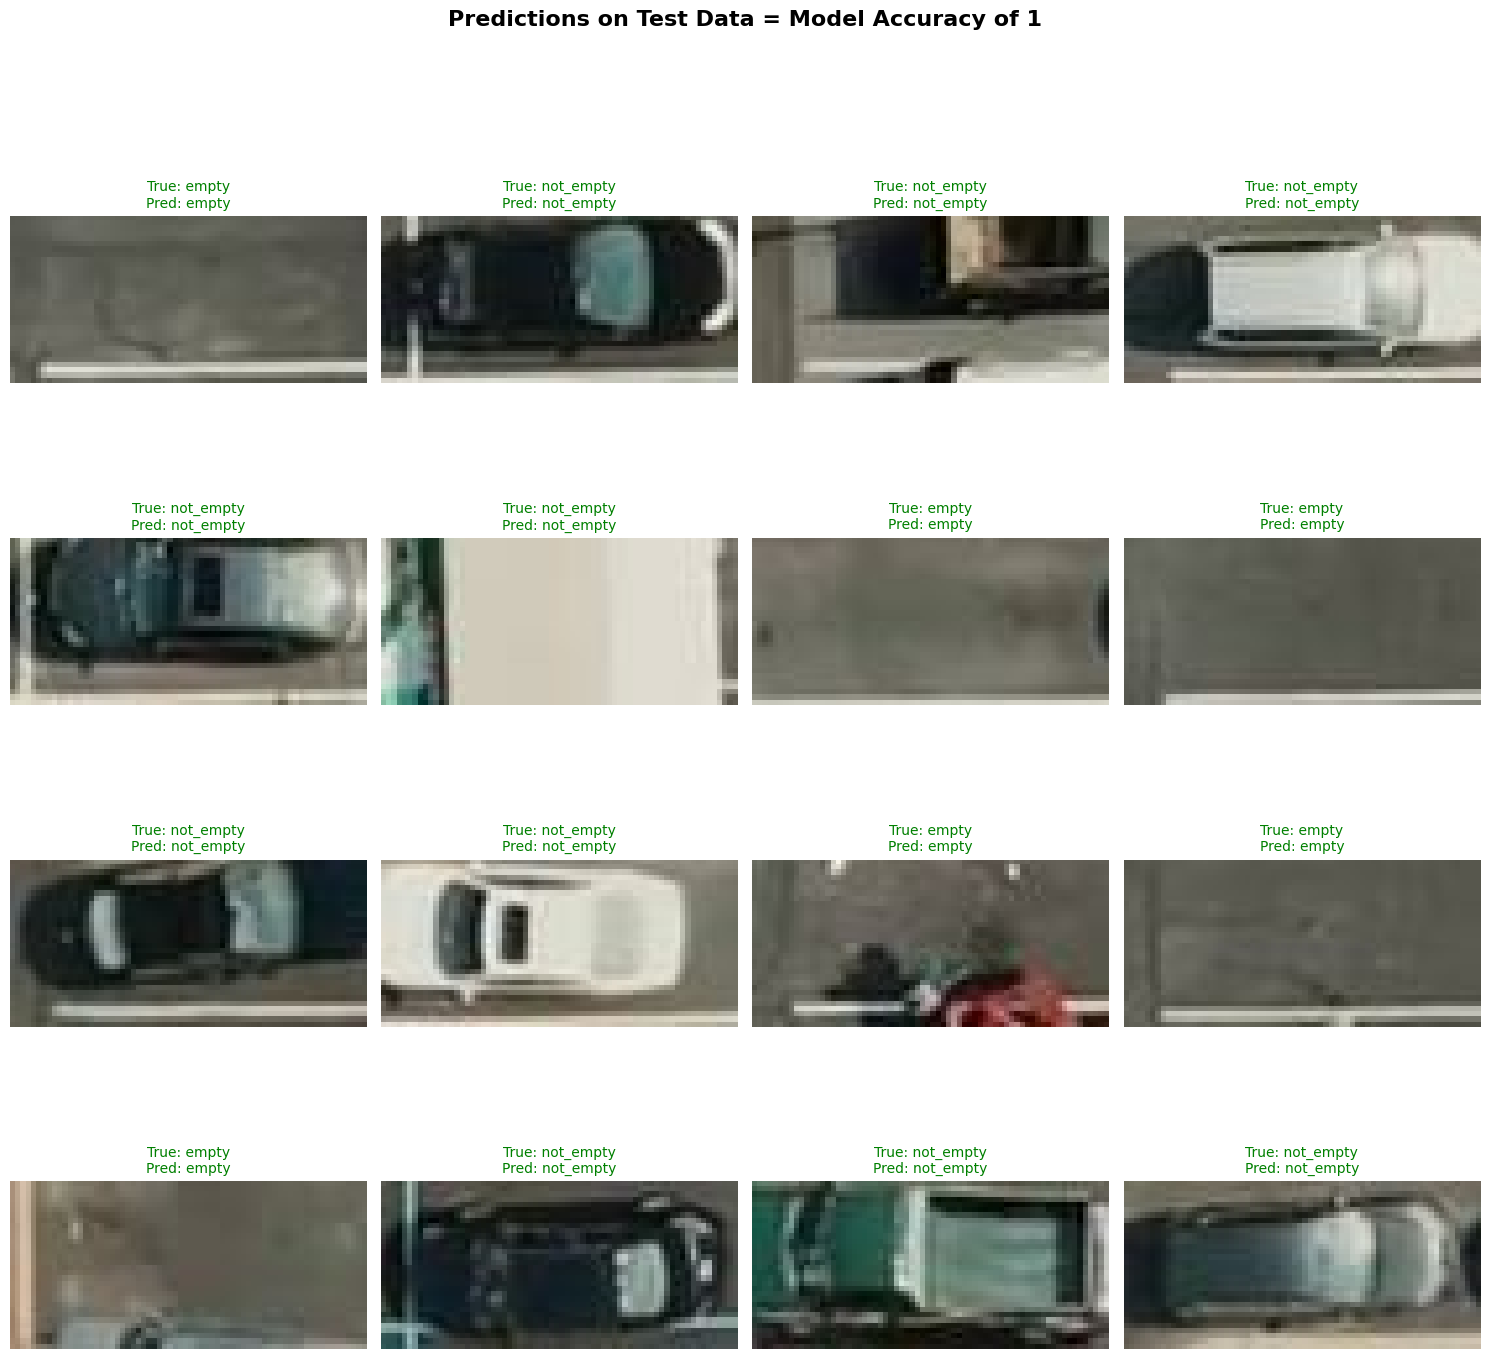

In [57]:
# Get a batch of test data
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

# Generate predictions
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1).numpy()  # Apply threshold for binary classification

# Visualize predictions
plt.figure(figsize=(15, 15))
for i in range(16):  # Increase the number of images to 16
    ax = plt.subplot(4, 4, i + 1)  # Adjust the grid to 4x4
    plt.imshow(image_batch[i].astype("uint8"))
    true_label = label_batch[i]
    pred_label = predictions[i]
    title = f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}"
    color = 'green' if true_label == pred_label else 'red'
    plt.title(title, color=color, fontsize=10)  # Make the font size smaller
    plt.axis("off")
plt.suptitle("Predictions on Test Data = Model Accuracy of 1", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()